In [1]:
# Import required libraries
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import train_test_split, cross_validate, LeaveOneOut
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import BaselineOnly, CoClustering
# import recmetrics as recmetrics ---> https://morioh.com/p/7208a4c1946d

import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

##csv usados
df_voting = pd.read_csv("../data/usa/HS117_votes.csv", sep=',')
df_members = pd.read_csv("../data/usa/HS117_members.csv", sep=',')

In [2]:
def evaluate_algorithms_binary(trainset, testset, algorithms):
    """
    Evaluate a list of algorithms on a given dataset using a train/test split with binary ratings.
    """
    # Initialize dictionary to store results
    results = {}
    
    # Iterate over all algorithms
    for algorithm in algorithms:
        # Train the algorithm on the training set
        algorithm.fit(trainset)
            
        # Test the algorithm on the test set
        predictions = algorithm.test(testset)
        
         # Calculate evaluation metrics
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        
        # Convert the predicted ratings to binary values (0 or 1)
        binary_predictions = [1 if p.est >= 0.5 else 0 for p in predictions]
        binary_true_ratings = [1 if p.r_ui >= 0.5 else 0 for p in predictions]
    
        # Calculate evaluation metrics
        acc = accuracy_score(binary_true_ratings, binary_predictions)
        precision, recall, f1_score, _ = precision_recall_fscore_support(binary_true_ratings, binary_predictions, average='binary')
        
        # Generate the confusion matrix
        tn, fp, fn, tp = confusion_matrix(binary_true_ratings, binary_predictions).ravel()
        matrix = pd.DataFrame({'Actual 0': [tn, fn], 'Actual 1': [fp, tp]}, index=['Predicted 0', 'Predicted 1'])
        
        # Store results in dictionary
        results[algorithm.__class__.__name__] = {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'test_rmse': rmse,
            'test_mae': mae,
        }
    
    # Convert dictionary to DataFrame and sort by F1 score
    results = pd.DataFrame.from_dict(results, orient='index')
    # matrix = pd.DataFrame.from_dict(matrix, orient="index")
    results = results.sort_values('f1_score', ascending=False)
    
    return results,matrix

df_voting has 6 columns:
    congress: number of the congress that this member's row
    chamber: House/Senate/President
    rollnumber: the first rollcall of each congress ~ initial roll call vote that takes place at the beginning of a new session of a legislative body, such as a congress or parliament
    icpsr: id code identifying each member (note: some members can have more than one icpsr - this can occur when member switch parties or becomes president)
    cast_code: 1-9 - how it voted
    prob: estimated probability of the member making the vote as recorded (BASED ON NOMINATE - variables with 2 dimensions in df_members)

In [3]:
df_voting

,congress,chamber,rollnumber,icpsr,cast_code,prob
0,117,House,1,14066.0,6,100.0
1,117,House,1,14854.0,6,100.0
2,117,House,1,14863.0,6,99.7
3,117,House,1,14873.0,1,100.0
4,117,House,1,15019.0,1,92.8
...,...,...,...,...,...,...
524118,117,Senate,949,42105.0,1,100.0
524119,117,Senate,949,49300.0,1,100.0
524120,117,Senate,949,49308.0,1,100.0
524121,117,Senate,949,49703.0,1,99.9


In [4]:
df_members

,congress,chamber,icpsr,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,...,died,nominate_dim1,nominate_dim2,nominate_log_likelihood,nominate_geo_mean_probability,nominate_number_of_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2
0,117,President,99912,99,0,USA,200,0.0,0.0,"TRUMP, Donald John",...,NaN,0.403,0.162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,117,President,99913,99,0,USA,100,0.0,0.0,"BIDEN, Joseph Robinette, Jr.",...,NaN,-0.320,0.283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,117,House,20301,41,3,AL,200,NaN,NaN,"ROGERS, Mike Dennis",...,NaN,0.362,0.462,-87.32931,0.89767,809.0,31.0,NaN,0.419,0.537
3,117,House,21102,41,7,AL,100,NaN,NaN,"SEWELL, Terri",...,NaN,-0.395,0.398,-22.46170,0.97317,826.0,9.0,NaN,-0.492,0.475
4,117,House,21193,41,5,AL,200,NaN,NaN,"BROOKS, Mo",...,NaN,0.652,-0.417,-168.03035,0.81410,817.0,80.0,NaN,0.697,-0.288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,117,Senate,40915,56,0,WV,100,NaN,NaN,"MANCHIN, Joe, III",...,NaN,-0.059,0.408,-84.19666,0.90694,862.0,27.0,NaN,-0.078,0.381
555,117,Senate,29940,25,0,WI,100,NaN,NaN,"BALDWIN, Tammy",...,NaN,-0.492,-0.135,-22.33177,0.97538,896.0,10.0,NaN,-0.467,-0.027
556,117,Senate,41111,25,0,WI,200,NaN,NaN,"JOHNSON, Ron",...,NaN,0.626,-0.141,-138.44529,0.85018,853.0,59.0,NaN,0.617,0.035
557,117,Senate,20953,68,0,WY,200,NaN,NaN,"LUMMIS, Cynthia M.",...,NaN,0.693,-0.347,-143.45400,0.84587,857.0,62.0,NaN,0.722,-0.361


In [5]:
merged_df = df_voting.merge(df_members, on='icpsr', how='outer')

In [6]:
merged_df.columns

Index(['congress_x', 'chamber_x', 'rollnumber', 'icpsr', 'cast_code', 'prob',
       'congress_y', 'chamber_y', 'state_icpsr', 'district_code',
       'state_abbrev', 'party_code', 'occupancy', 'last_means', 'bioname',
       'bioguide_id', 'born', 'died', 'nominate_dim1', 'nominate_dim2',
       'nominate_log_likelihood', 'nominate_geo_mean_probability',
       'nominate_number_of_votes', 'nominate_number_of_errors', 'conditional',
       'nokken_poole_dim1', 'nokken_poole_dim2'],
      dtype='object')

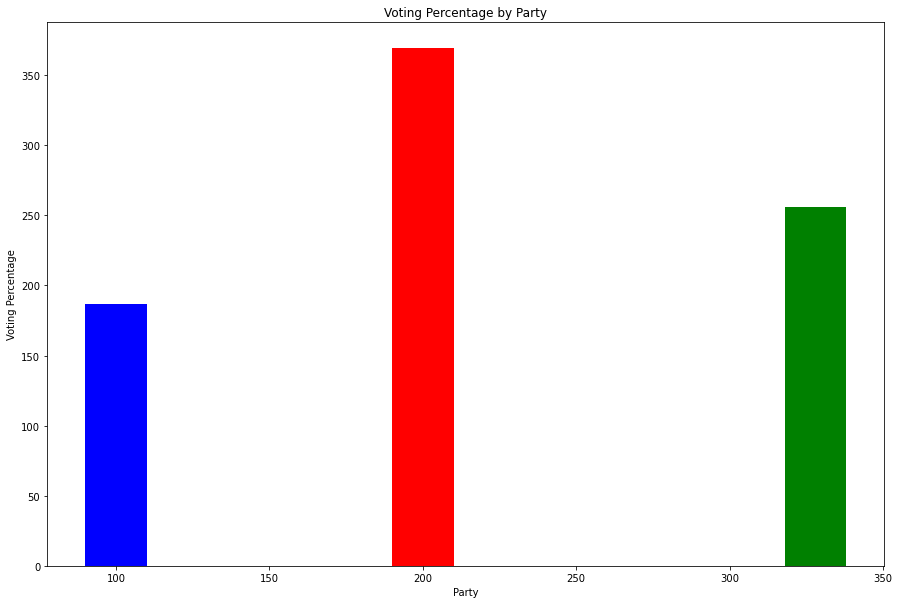

In [7]:
# Calculate the percentage of votes by party
party_colors = {100: 'blue', 200: 'red', 328: 'green'}  # Add more colors as needed
voting_percentage_by_party = merged_df.groupby('party_code')['cast_code'].mean() * 100

# Get the party codes for the voting percentage data
party_codes = voting_percentage_by_party.index

# Plotting the voting percentage by party with colored bars
plt.figure(figsize=(15, 10))
plt.bar(voting_percentage_by_party.index, voting_percentage_by_party, color=[party_colors.get(code, 'gray') for code in party_codes], width=20)

# Customize the plot
plt.title('Voting Percentage by Party')
plt.xlabel('Party')
plt.ylabel('Voting Percentage')
plt.xticks(rotation=0)

# Show plot
plt.show()

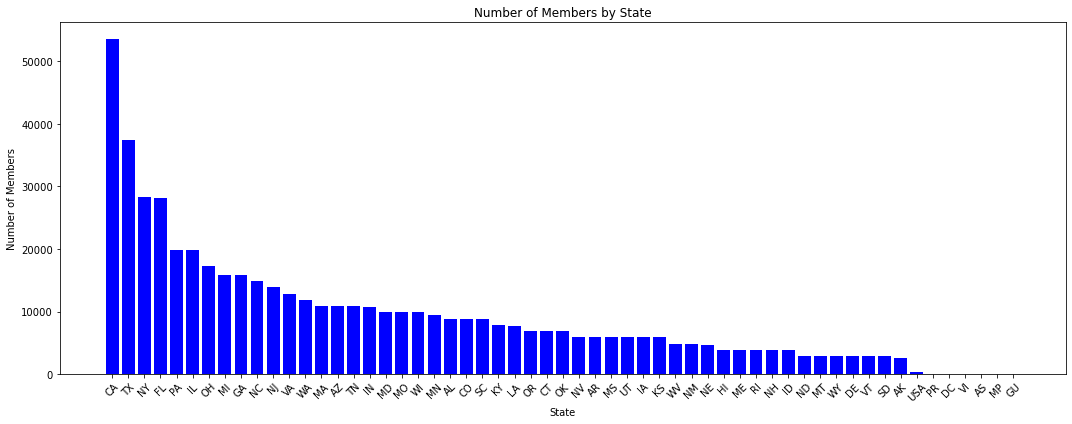

In [8]:
member_count_by_state = merged_df['state_abbrev'].value_counts()
# Create a larger figure
plt.figure(figsize=(15, 6))
# Create a bar plot
plt.bar(member_count_by_state.index, member_count_by_state.values, color='blue')

# Customize the plot
plt.title('Number of Members by State')
plt.xlabel('State')
plt.ylabel('Number of Members')
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

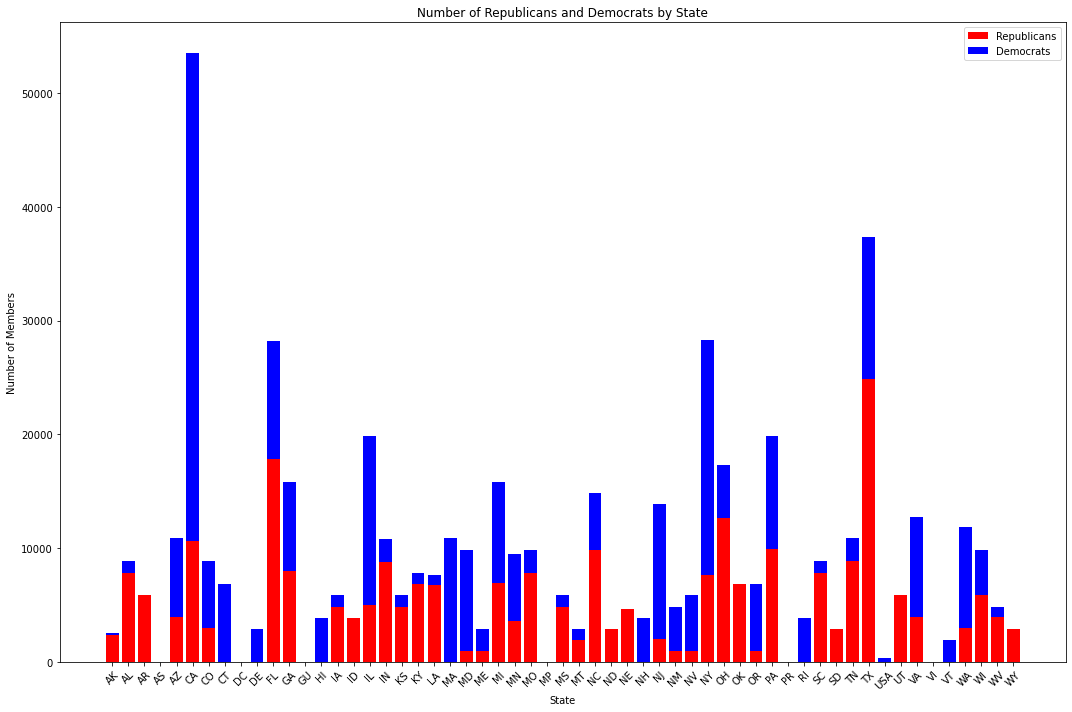

In [9]:
# Filter the data for Republicans and Democrats
republicans = merged_df[merged_df['party_code'] == 200]
democrats = merged_df[merged_df['party_code'] == 100]

# Calculate the count of Republicans and Democrats by state
republican_count_by_state = republicans['state_abbrev'].value_counts()
democrat_count_by_state = democrats['state_abbrev'].value_counts()

# Get all unique states
all_states = np.unique(np.concatenate([republican_count_by_state.index, democrat_count_by_state.index]))

# Fill missing states with zero counts
republican_count_by_state = republican_count_by_state.reindex(all_states, fill_value=0)
democrat_count_by_state = democrat_count_by_state.reindex(all_states, fill_value=0)

# Create a larger figure
plt.figure(figsize=(15, 10))

# Create a stacked bar plot
plt.bar(republican_count_by_state.index, republican_count_by_state.values, label='Republicans', color='red')
plt.bar(democrat_count_by_state.index, democrat_count_by_state.values, bottom=republican_count_by_state.values, label='Democrats', color='blue')

# Customize the plot
plt.title('Number of Republicans and Democrats by State')
plt.xlabel('State')
plt.ylabel('Number of Members')
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


"We present two main estimates of a legislator's ideology: NOMINATE and Nokken-Poole. NOMINATE estimates assume that members occupy a static ideological position across the course of their career. Nokken-Poole estimates assume that each congress is completely separate for the purposes of estimating a member's ideology. We expect that most users of our data will primarily make use of the nominate_dim1 field, which reports the first dimension (often interpreted as economic liberalism-conservatism) of members as estimated by NOMINATE"

    100: Democratic Party
    200: Republican Party
    .
    328: Independent

In [10]:
df_members

,congress,chamber,icpsr,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,...,died,nominate_dim1,nominate_dim2,nominate_log_likelihood,nominate_geo_mean_probability,nominate_number_of_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2
0,117,President,99912,99,0,USA,200,0.0,0.0,"TRUMP, Donald John",...,NaN,0.403,0.162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,117,President,99913,99,0,USA,100,0.0,0.0,"BIDEN, Joseph Robinette, Jr.",...,NaN,-0.320,0.283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,117,House,20301,41,3,AL,200,NaN,NaN,"ROGERS, Mike Dennis",...,NaN,0.362,0.462,-87.32931,0.89767,809.0,31.0,NaN,0.419,0.537
3,117,House,21102,41,7,AL,100,NaN,NaN,"SEWELL, Terri",...,NaN,-0.395,0.398,-22.46170,0.97317,826.0,9.0,NaN,-0.492,0.475
4,117,House,21193,41,5,AL,200,NaN,NaN,"BROOKS, Mo",...,NaN,0.652,-0.417,-168.03035,0.81410,817.0,80.0,NaN,0.697,-0.288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,117,Senate,40915,56,0,WV,100,NaN,NaN,"MANCHIN, Joe, III",...,NaN,-0.059,0.408,-84.19666,0.90694,862.0,27.0,NaN,-0.078,0.381
555,117,Senate,29940,25,0,WI,100,NaN,NaN,"BALDWIN, Tammy",...,NaN,-0.492,-0.135,-22.33177,0.97538,896.0,10.0,NaN,-0.467,-0.027
556,117,Senate,41111,25,0,WI,200,NaN,NaN,"JOHNSON, Ron",...,NaN,0.626,-0.141,-138.44529,0.85018,853.0,59.0,NaN,0.617,0.035
557,117,Senate,20953,68,0,WY,200,NaN,NaN,"LUMMIS, Cynthia M.",...,NaN,0.693,-0.347,-143.45400,0.84587,857.0,62.0,NaN,0.722,-0.361


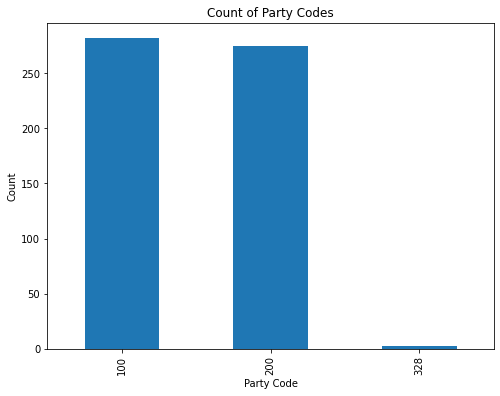

In [11]:
# df_members['party_code'].value_counts()# Calculate the count of party codes
party_code_counts = df_members['party_code'].value_counts()

# Plotting the count of party codes
plt.figure(figsize=(8, 6))
party_code_counts.plot(kind='bar')
plt.title('Count of Party Codes')
plt.xlabel('Party Code')
plt.ylabel('Count')

# Show plot
plt.show()

In [12]:
df_voting["rollnumber"].value_counts()

883    538
881    538
880    538
819    536
828    536
      ... 
971    430
970    430
969    430
968    430
978    430
Name: rollnumber, Length: 996, dtype: int64

In [13]:
df_voting["cast_code"].value_counts()

1    345885
6    166176
9     11964
7        98
Name: cast_code, dtype: int64

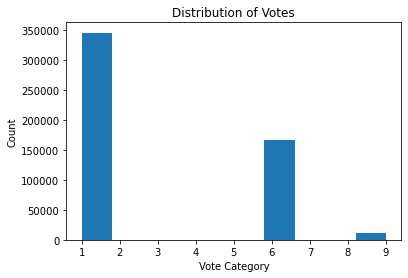

In [14]:
# Plotting the distribution of votes
plt.hist(df_voting['cast_code'], bins=10)

# Customize the plot
plt.title('Distribution of Votes')
plt.xlabel('Vote Category')
plt.ylabel('Count')

# Show plot
plt.show()

In [15]:
## create a new dataframe with only the yes or no votes -- 1 (yes) 6(no)
df_bool = df_voting.loc[(df_voting["cast_code"] == 1) | (df_voting["cast_code"] == 6)] 

In [16]:
df_bool["cast_code"].replace({6: 0}, inplace=True)

C:\Users\ritac\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
df_bool

,congress,chamber,rollnumber,icpsr,cast_code,prob
0,117,House,1,14066.0,0,100.0
1,117,House,1,14854.0,0,100.0
2,117,House,1,14863.0,0,99.7
3,117,House,1,14873.0,1,100.0
4,117,House,1,15019.0,1,92.8
...,...,...,...,...,...,...
524118,117,Senate,949,42105.0,1,100.0
524119,117,Senate,949,49300.0,1,100.0
524120,117,Senate,949,49308.0,1,100.0
524121,117,Senate,949,49703.0,1,99.9


### Distribution and Heatmap of Vote Ratings

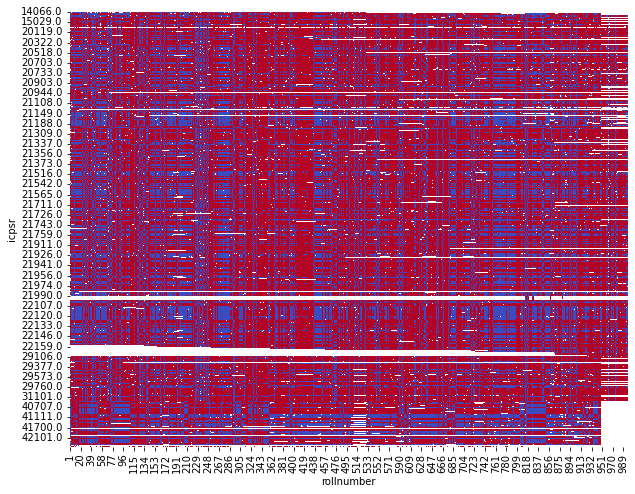

In [18]:
pivot_table = df_bool.pivot_table(index='icpsr', columns='rollnumber', values='cast_code')

# Create a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pivot_table, cmap='coolwarm', cbar=False)
plt.show()

In [21]:
data = df_bool['cast_code'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df_bool.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} vote-ratings'.format(df_bool.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Algorithms Analysis 

In [22]:
# Create the reader
reader = Reader(rating_scale=(0, 1))
# Load the data into a dataset
data = Dataset.load_from_df(df_bool[['icpsr', 'rollnumber', 'cast_code']], reader)

# Split the data into a training set and a test set
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

In [23]:
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results,matrix = evaluate_algorithms_binary(trainset,testset, algorithms)

RMSE: 0.1798
MAE:  0.0934
RMSE: 0.3889
MAE:  0.3170
RMSE: 0.2341
MAE:  0.1815
RMSE: 0.5796
MAE:  0.4566
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1723
MAE:  0.0654
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1724
MAE:  0.0659
Estimating biases using als...
RMSE: 0.3895
MAE:  0.3189
RMSE: 0.2546
MAE:  0.1436


In [24]:
results

,accuracy,precision,recall,f1_score,test_rmse,test_mae
KNNWithMeans,0.959903,0.965043,0.976011,0.970496,0.172389,0.065861
KNNBaseline,0.959841,0.965008,0.975953,0.970450,0.172346,0.065404
SVD,0.959279,0.964098,0.976080,0.970052,0.179816,0.093386
NMF,0.949053,0.965561,0.958796,0.962167,0.234138,0.181543
CoClustering,0.908769,0.918745,0.948900,0.933579,0.254586,0.143643
SlopeOne,0.799220,0.828922,0.885626,0.856336,0.388865,0.316960
BaselineOnly,0.798353,0.827256,0.886724,0.855958,0.389520,0.318930
NormalPredictor,0.550767,0.675112,0.646022,0.660247,0.579554,0.456553


### Realistic Problem

In [26]:
## create dataset with users descriptors 
df2 = pd.merge(df_bool,df_members, on ='icpsr')
df2[['icpsr', 'rollnumber', 'cast_code']].value_counts().to_frame().rename(columns={0:'repetitions'})

## datatset with voting and orientation of each party for each voting id
df2 = df2.drop_duplicates(subset=['icpsr', 'rollnumber', 'cast_code'], keep='first').reset_index(drop=True)

In [27]:
df2["icpsr"].value_counts() ##members that have less than x entries?

21740.0    996
21178.0    996
22114.0    996
21526.0    996
20706.0    996
          ... 
21993.0     13
21997.0     12
99912.0      6
41904.0      2
41701.0      2
Name: icpsr, Length: 558, dtype: int64

In [28]:
df2["rollnumber"].value_counts() ##voting count - 996 votings happened

485    534
398    534
486    534
403    533
371    533
      ... 
985    409
979    409
978    409
961    388
962    356
Name: rollnumber, Length: 996, dtype: int64

In [29]:
def get_top_users_by_error(predictions, dataset ,n=10, ascending=True):
    user_errors = {}

    # Calculate the error for each user
    for pred in predictions:
        uid = pred.uid
        error = abs(pred.est - pred.r_ui)

        if uid in user_errors:
            user_errors[uid] += error
        else:
            user_errors[uid] = error
    
    # Sort the users based on the total error in ascending or descending order
    sorted_users = sorted(user_errors.items(), key=lambda x: x[1], reverse=not ascending)

    # top users
    top_users = [(dataset.loc[dataset['icpsr'] == user[0], 'bioname'].values[0],
                  dataset.loc[dataset['icpsr'] == user[0], 'party_code'].values[0],
                  user[1]) for user in sorted_users[:n]]
    
    return top_users


def clusters_users(predictions, num_clusters=10):
    user_ratings = {}  # Dictionary to store user ratings by cluster

    # Collect user ratings for each cluster
    for p in predictions:
        if p.uid not in user_ratings:
            user_ratings[p.uid] = {'True Rating': [], 'Predicted Rating': []}
        user_ratings[p.uid]['True Rating'].append(p.r_ui)
        user_ratings[p.uid]['Predicted Rating'].append(p.est)

    # Prepare the data for clustering
    data = []
    for uid, ratings in user_ratings.items():
        data.append([sum(ratings['True Rating']) / len(ratings['True Rating']), sum(ratings['Predicted Rating']) / len(ratings['Predicted Rating'])])

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(data)

    # Add cluster labels to the user ratings dictionary
    for i, uid in enumerate(user_ratings):
        user_ratings[uid]['Cluster'] = cluster_labels[i]

    # Prepare the data for visualization
    data = []
    for uid, ratings in user_ratings.items():
        for true_rating, predicted_rating in zip(ratings['True Rating'], ratings['Predicted Rating']):
            data.append({'User ID': uid, 'Cluster': ratings['Cluster'], 'True Rating': true_rating, 'Predicted Rating': predicted_rating})

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Group users by cluster and calculate average true rating and predicted rating
    grouped_df = df.groupby(['Cluster', 'User ID']).agg({'True Rating': 'mean', 'Predicted Rating': 'mean'})
    grouped_df = grouped_df.reset_index()

    return grouped_df

 
def evaluate_algorithms_binary(trainset, testset, algorithms, dt):
  
    results = {}    
    for algorithm in algorithms:
        # train 
        algorithm.fit(trainset)
        
        # test
        predictions = algorithm.test(testset)

        # predicted ratings to 0 or 1 
        binary_predictions = [1 if p.est >= 0.5 else 0 for p in predictions]
        
        # binary_true_ratings is not needed -> does not change anything
        binary_true_ratings = [1 if p.r_ui >= 0.5 else 0 for p in predictions]

        # Metrics
        acc = accuracy_score(binary_true_ratings, binary_predictions)
        precision, recall, f1_score, _ = precision_recall_fscore_support(binary_true_ratings, binary_predictions, average='binary')
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        
        # Store results in dictionary
        results[algorithm.__class__.__name__] = {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'test_rmse': rmse,
            'test_mae': mae,
        }

    # Convert dictionary to DataFrame and sort by F1 score
    results = pd.DataFrame.from_dict(results, orient='index')
    top10_high = get_top_users_by_error(predictions,dt, n=10, ascending=False)
    top10_low = get_top_users_by_error(predictions,dt, n=10, ascending=True)
    return results, top10_high,top10_low

def realistic_train_test(algorithms, dt, n=0.1):
    reader = Reader(rating_scale=(0, 1))
    dt = dt.sort_values(by='rollnumber')
    data = Dataset.load_from_df(dt[['icpsr', 'rollnumber', 'cast_code']], reader)
    
    # first ~900 votes
    train_indices = dt['rollnumber'].unique()[:900]
    # last ~10% of votes
    test_indices = dt['rollnumber'].unique()[-96:]

    train_data = dt[dt['rollnumber'].isin(train_indices)]
    test_data = pd.DataFrame()

    for test_index in test_indices:
        test_votes = dt[dt['rollnumber'] == test_index]

        #10% of the votes for the train set
        size = int(len(test_votes) * n)
        
        #randomly select n rows from test_votes to into the train data
        train_votes = test_votes.sample(n=size, random_state=42)

        # add to train set
        train_data = pd.concat([train_data, train_votes])

        # remaining votes for the test set
        test_votes = test_votes[~test_votes.index.isin(train_votes.index)]
        test_data = pd.concat([test_data, test_votes])
        
    # remaining votes to train - it removes what was already used for test
    train_data = dt[~dt[['icpsr', 'rollnumber']].isin(test_data[['icpsr', 'rollnumber']]).all(axis=1)]

    trainset = Dataset.load_from_df(train_data[['icpsr', 'rollnumber', 'cast_code']], reader).build_full_trainset()
    testset = Dataset.load_from_df(test_data[['icpsr', 'rollnumber', 'cast_code']], reader).build_full_trainset().build_testset()

    # ## use function to evaluate results
    results, top10_high, top10_low = evaluate_algorithms_binary(trainset,testset, algorithms, dt)
    return results, top10_high, top10_low

In [42]:
## 10% de teste no train
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results1,top10_high, top10_low = realistic_train_test(algorithms, df2)
results1

RMSE: 0.2430
MAE:  0.1607
RMSE: 0.3337
MAE:  0.2568
RMSE: 0.2415
MAE:  0.1794
RMSE: 0.5658
MAE:  0.4393
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2939
MAE:  0.2132
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2940
MAE:  0.2131
Estimating biases using als...
RMSE: 0.3375
MAE:  0.2654


KeyboardInterrupt: 

In [ ]:
results5,top10_high, top10_low = realistic_train_test(algorithms, df2, n=0.05)
results5

In [ ]:
results2,top10_high, top10_low = realistic_train_test(algorithms, df2, n=0.02)
results2

In [55]:
n_values = [0.02, 0.05, 0.1]
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
n_list = []
results_dict = {}

for n in n_values:
    # Generate results and other data based on the value of n
    results, top10_high, top10_low = realistic_train_test(algorithms, df2, n)
    # Get the F1-scores from the results for each algorithm
    f1_scores = results['f1_score']
    results_dict[n] = f1_scores

RMSE: 0.3211
MAE:  0.2582
RMSE: 0.3448
MAE:  0.2598
RMSE: 0.2636
MAE:  0.1912
RMSE: 0.5658
MAE:  0.4404
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3213
MAE:  0.2358
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3214
MAE:  0.2353
Estimating biases using als...
RMSE: 0.3532
MAE:  0.2902
RMSE: 0.3101
MAE:  0.1744
RMSE: 0.2759
MAE:  0.1990
RMSE: 0.3371
MAE:  0.2570
RMSE: 0.2478
MAE:  0.1815
RMSE: 0.5660
MAE:  0.4411
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3116
MAE:  0.2315
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3115
MAE:  0.2310
Estimating biases using als...
RMSE: 0.3427
MAE:  0.2719
RMSE: 0.2985
MAE:  0.1665
RMSE: 0.2425
MAE:  0.1606
RMSE: 0.3337
MAE:  0.2568
RMSE: 0.2420
MAE:  0.1796
RMSE: 0.5694
MAE:  0.4444
Estimating biases using als...
Computing the msd similarity matr

In [74]:
# Create a DataFrame from the results dictionary
df_results = pd.DataFrame(results_dict)
# Sort the columns alphabetically
df_results = df_results.reindex(sorted(df_results.columns), axis=1)
df_results

,0.02,0.05,0.10
SVD,0.920097,0.940606,0.951114
SlopeOne,0.907439,0.913874,0.915036
NMF,0.940508,0.949280,0.953937
NormalPredictor,0.689690,0.688886,0.686878
KNNBaseline,0.918598,0.920402,0.928306
KNNWithMeans,0.918776,0.920689,0.927873
BaselineOnly,0.905540,0.915383,0.915526
CoClustering,0.923510,0.927391,0.937114


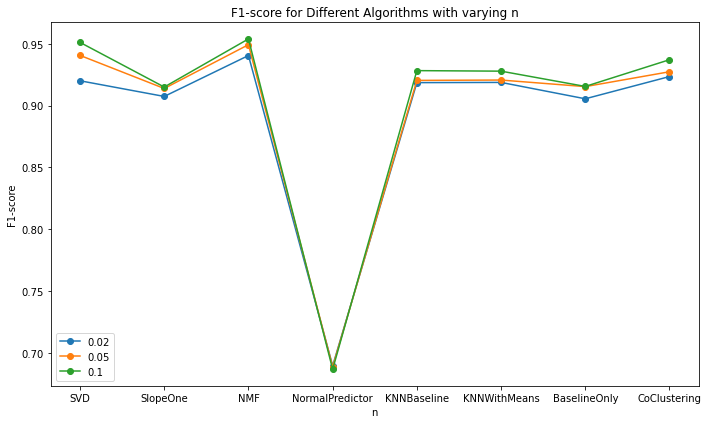

In [72]:

# Plot the results
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
for algorithm in df_results.columns:
    plt.plot(df_results.index, df_results[algorithm], marker='o', label=algorithm)

plt.xlabel('n')
plt.ylabel('F1-score')
plt.title('F1-score for Different Algorithms with varying n')
plt.legend()
plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [57]:
f1_score

Series([], Name: f1_score, dtype: float64)

In [58]:
##n_factors: 100, n_epochs:20, biased:True, lr_all: 0.005, reg_all:0.02
algorithms = [NMF()]
results2,top10_high, top10_low = realistic_train_test(algorithms, df2)
results2

RMSE: 0.2632
MAE:  0.1915


,accuracy,precision,recall,f1_score,test_rmse,test_mae
NMF,0.912556,0.93705,0.946342,0.941673,0.263179,0.191486


In [59]:
print("Top 10 Users with the Highest Errors:")
for user_name, user_partido, error in top10_high:
    print(f"{user_name} ({user_partido}), Error: {error}")

Top 10 Users with the Highest Errors:
BROOKS, Mo (200), Error: 33.81637609248674
GAETZ, Matthew L. II (200), Error: 33.631387275811676
McCLINTOCK, Tom (200), Error: 31.645826246180466
VAN DREW, Jefferson (200), Error: 30.92640625616432
BISHOP, Dan (200), Error: 30.91551493576322
CLYDE, Andrew S. (200), Error: 30.302791186919613
HICE, Jody Brownlow (200), Error: 30.207015373982898
GOSAR, Paul (200), Error: 29.974084745277263
CLOUD, Michael (200), Error: 29.96683323312612
BURCHETT, Timothy (200), Error: 29.929813908838895


In [60]:
print("Top 10 Users with the Lowest Errors:")
for user_name, user_partido, error in top10_low:
    print(f"{user_name} ({user_partido}), Error: {error}")

Top 10 Users with the Lowest Errors:
PELOSI, Nancy (100), Error: 1.8027374296110916
DEUTCH, Theodore E. (Ted) (100), Error: 2.7465709206637468
MCEACHIN, Aston Donald (100), Error: 3.536101304191786
BARRASSO, John A. (200), Error: 4.702549006667675
KINZINGER, Adam (200), Error: 6.600743202764684
BURR, Richard M. (200), Error: 6.849313266409758
BASS, Karen (100), Error: 6.965124264342071
YARMUTH, John (100), Error: 7.253111144497165
CRUZ, Rafael Edward (Ted) (200), Error: 8.216709405576044
HICKENLOOPER, John Wright (100), Error: 8.38835131453896


In [52]:
##percentagem de valores NULL no dataset
percent= df2.isnull().sum() * 100 / len(df)
missing_value = pd.DataFrame({'percent_missing': percent})
missing_value.sort_values('percent_missing', inplace=True)
missing_value

,percent_missing
congress_x,0.000000
born,0.000000
bioname,0.000000
party_code,0.000000
state_abbrev,0.000000
nominate_dim1,0.000000
state_icpsr,0.000000
district_code,0.000000
congress_y,0.000000
cast_code,0.000000


In [57]:
## nr of votings
df2["rollnumber"].value_counts()

880    538
881    538
883    538
818    536
858    536
      ... 
971    430
970    430
969    430
968    430
978    430
Name: rollnumber, Length: 996, dtype: int64

In [58]:

## nr of members
df2["icpsr"].value_counts()

21926.0    996
21949.0    996
21946.0    996
21945.0    996
21944.0    996
          ... 
21997.0     14
21992.0     14
99912.0      6
41701.0      2
41904.0      2
Name: icpsr, Length: 559, dtype: int64